In [17]:
!pip install --upgrade scikit-learn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score
from scipy.stats import zscore
from datetime import datetime
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

**Loading Dataset**

In [18]:
file_path = "/content/data.csv"  # Path

df = pd.read_csv(file_path, encoding='ISO-8859-1')
df = df.dropna(subset=['CustomerID'])  # Drop missing customer IDs

df['TotalSpend'] = df['Quantity'] * df['UnitPrice']  # Compute total spend
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])  # Convert to datetime
latest_date = df['InvoiceDate'].max()  # Find the latest transaction date

# Aggregate customer data
customer_data = df.groupby('CustomerID').agg(
    TotalSpent=('TotalSpend', 'sum'),
    NumTransactions=('InvoiceNo', 'nunique'),
    ItemsBought=('Quantity', 'sum'),
    Recency=('InvoiceDate', lambda x: (latest_date - x.max()).days)
).reset_index()


**Removing Outliers using Z-score**

In [19]:
customer_data['Z_TotalSpent'] = zscore(customer_data['TotalSpent'])
customer_data['Z_NumTransactions'] = zscore(customer_data['NumTransactions'])
customer_data['Z_ItemsBought'] = zscore(customer_data['ItemsBought'])

customer_data = customer_data[
    (customer_data['Z_TotalSpent'].abs() < 3) &
    (customer_data['Z_NumTransactions'].abs() < 3) &
    (customer_data['Z_ItemsBought'].abs() < 3)
]
customer_data.drop(columns=['Z_TotalSpent', 'Z_NumTransactions', 'Z_ItemsBought'], inplace=True)

<ipython-input-19-112410ef40b2>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  customer_data.drop(columns=['Z_TotalSpent', 'Z_NumTransactions', 'Z_ItemsBought'], inplace=True)


** Normalizing Data and finding Optimal Clusters using Silhouette Score **

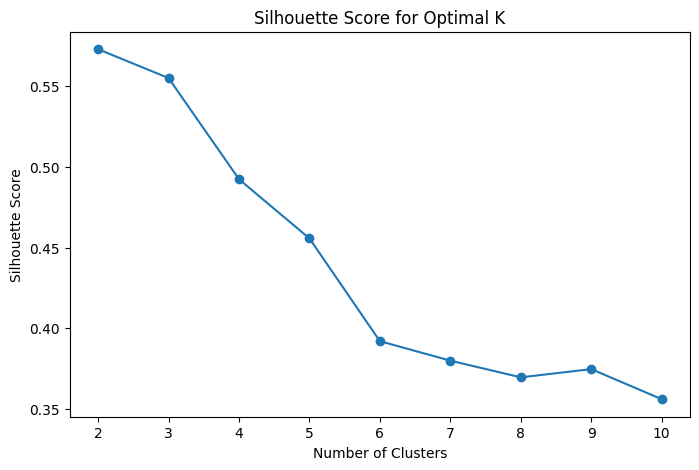

In [20]:
# Step : Normalize Data

scaler = MinMaxScaler()
customer_scaled = scaler.fit_transform(customer_data[['TotalSpent', 'NumTransactions', 'ItemsBought', 'Recency']])

# Find Optimal Clusters using Silhouette Score
silhouette_scores = []
K_range = range(2, 11)
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(customer_scaled)
    silhouette_scores.append(silhouette_score(customer_scaled, labels))

plt.figure(figsize=(8, 5))
plt.plot(K_range, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.show()

**K-means and hierarchical clustering **

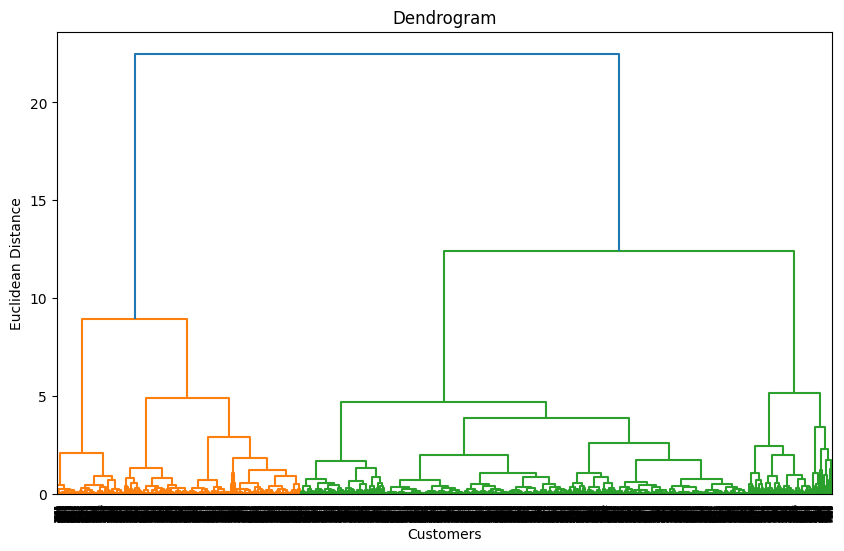

In [22]:
# Step : Apply K-Means Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

optimal_k = 4  # Choose the best K based on silhouette score
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_data['Cluster_KMeans'] = kmeans.fit_predict(customer_scaled)

# Step : Apply Hierarchical Clustering
plt.figure(figsize=(10, 6))
dendrogram = sch.dendrogram(sch.linkage(customer_scaled, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distance')
plt.show()

# Update the AgglomerativeClustering initialization to use the 'metric' parameter instead of 'affinity'
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, metric='euclidean', linkage='ward')
customer_data['Cluster_Hierarchical'] = hierarchical.fit_predict(customer_scaled)

**DBSCAN and Comparing Clusters **

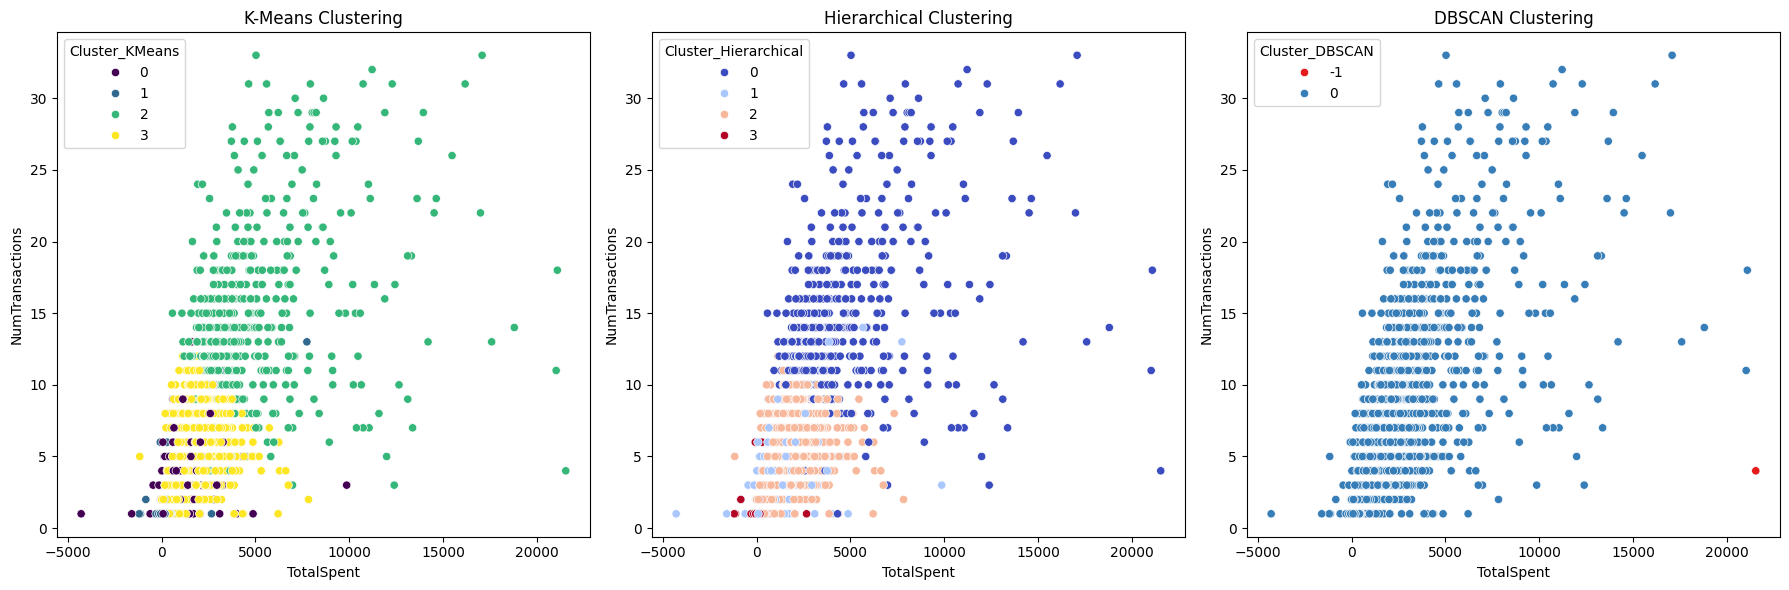

In [23]:
# Step: Apply DBSCAN Clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
customer_data['Cluster_DBSCAN'] = dbscan.fit_predict(customer_scaled)

# Step: Compare Clustering Methods
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.scatterplot(data=customer_data, x="TotalSpent", y="NumTransactions", hue="Cluster_KMeans", palette="viridis", ax=axes[0])
axes[0].set_title("K-Means Clustering")

sns.scatterplot(data=customer_data, x="TotalSpent", y="NumTransactions", hue="Cluster_Hierarchical", palette="coolwarm", ax=axes[1])
axes[1].set_title("Hierarchical Clustering")

sns.scatterplot(data=customer_data, x="TotalSpent", y="NumTransactions", hue="Cluster_DBSCAN", palette="Set1", ax=axes[2])
axes[2].set_title("DBSCAN Clustering")

plt.tight_layout()
plt.show()

**Export Data for Further Analysis**

In [24]:
customer_data.to_csv("refined_customer_segments.csv", index=False)
print("Refined customer segmentation data saved as 'refined_customer_segments.csv'")

Refined customer segmentation data saved as 'refined_customer_segments.csv'


**Comparison**

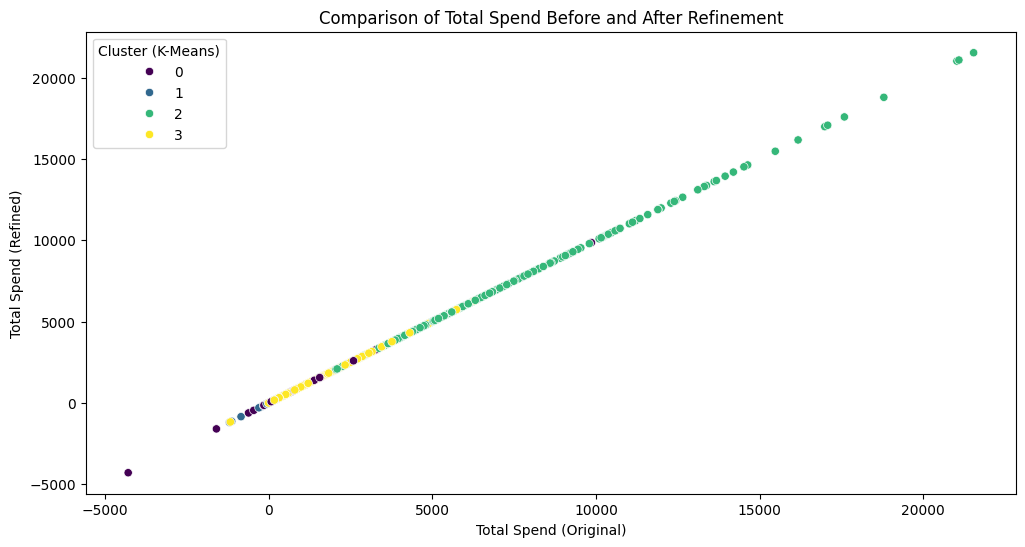

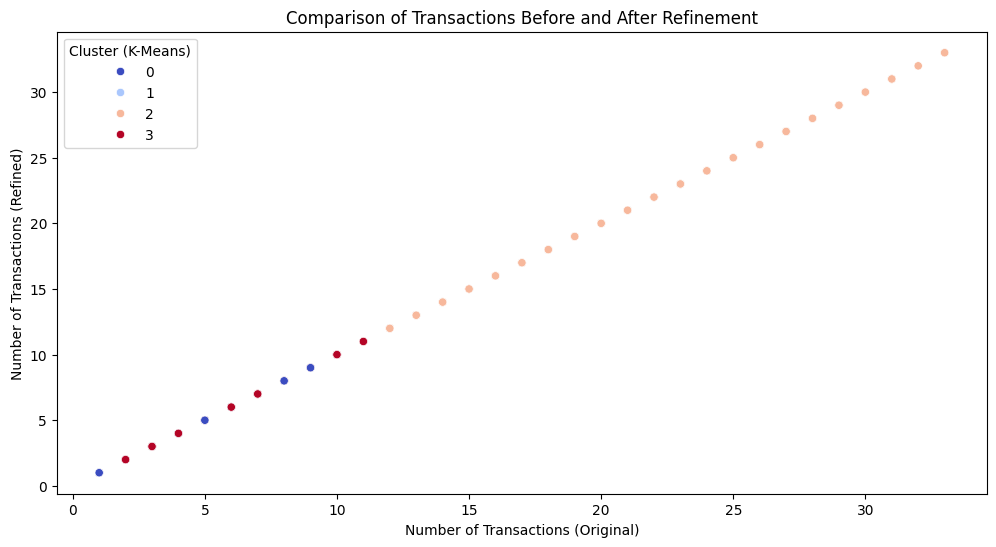

Comparison of Original and Refined Data:
   CustomerID  TotalSpent_Original  NumTransactions_Original  \
0     12346.0                 0.00                         2   
1     12347.0              4310.00                         7   
2     12348.0              1797.24                         4   
3     12349.0              1757.55                         1   
4     12350.0               334.40                         1   

   ItemsBought_Original  TotalSpent_Refined  NumTransactions_Refined  \
0                     0                0.00                        2   
1                  2458             4310.00                        7   
2                  2341             1797.24                        4   
3                   631             1757.55                        1   
4                   197              334.40                        1   

   ItemsBought_Refined  Recency  Cluster_KMeans  Cluster_Hierarchical  \
0                    0      325               1                     

In [26]:
# Re-import necessary libraries since the execution state was reset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the original dataset (data.csv) and refined dataset (refined_customer_segments.csv)
original_file_path = "/content/data.csv"
refined_file_path = "/content/refined_customer_segments.csv"

# Load datasets
df_original = pd.read_csv(original_file_path, encoding='ISO-8859-1')
df_refined = pd.read_csv(refined_file_path)

# Aggregate original dataset by CustomerID (same process as refined)
df_original['TotalSpend'] = df_original['Quantity'] * df_original['UnitPrice']
original_customer_data = df_original.groupby('CustomerID').agg(
    TotalSpent=('TotalSpend', 'sum'),
    NumTransactions=('InvoiceNo', 'nunique'),
    ItemsBought=('Quantity', 'sum')
).reset_index()

# Merge original and refined datasets for comparison
comparison_df = original_customer_data.merge(df_refined, on="CustomerID", suffixes=('_Original', '_Refined'))

# Plot comparison of TotalSpent before and after refinement
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x="TotalSpent_Original", y="TotalSpent_Refined", hue="Cluster_KMeans", palette="viridis")
plt.xlabel("Total Spend (Original)")
plt.ylabel("Total Spend (Refined)")
plt.title("Comparison of Total Spend Before and After Refinement")
plt.legend(title="Cluster (K-Means)")
plt.show()

# Plot comparison of NumTransactions before and after refinement
plt.figure(figsize=(12, 6))
sns.scatterplot(data=comparison_df, x="NumTransactions_Original", y="NumTransactions_Refined", hue="Cluster_KMeans", palette="coolwarm")
plt.xlabel("Number of Transactions (Original)")
plt.ylabel("Number of Transactions (Refined)")
plt.title("Comparison of Transactions Before and After Refinement")
plt.legend(title="Cluster (K-Means)")
plt.show()

# Display the merged dataset for further analysis
# import ace_tools as tools # Removed as the library is not available
# tools.display_dataframe_to_user(name="Comparison of Original and Refined Data", dataframe=comparison_df) # Removed as the library is not available
print("Comparison of Original and Refined Data:") # Print a title for the output data
print(comparison_df.head()) #Print the first 5 rows to display the dataframe